# Notes to self

* I need to address the datetime issue with daylight savings time. There are negative values in duration as a result of this. This part was addressed in the "Data Prep" section at the end. I will also need to do the EDA portion about average duration times after I fix this. Go through this course to see how to fix it: https://app.datacamp.com/learn/courses/working-with-dates-and-times-in-python

* See if I can geolocate the stations on something like Google Maps. This will really help the visualization. Take it a step further and highlight the 10 (or 20) most common routes.

# Overview

This project utilizes bike share data from Boston. The information records the starting station a user rented a bike and the ending station they dropped it off, as well as timestamps for those moments. It also contains general information on the user.

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime, timezone
from dateutil import tz

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Prep

In [2]:
rentaldata = pd.read_csv("hubwaydata_10_12_to_11_13.csv")
stationdata = pd.read_csv("stations_10_12_to_11_13.csv")

C:\Users\smith\AppData\Local\Temp\ipykernel_24868\172753715.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  rentaldata = pd.read_csv("hubwaydata_10_12_to_11_13.csv")


Let's look at the a snippet of the data along with the data types we have.

First, we will look at the rental data.

In [3]:
print(rentaldata.head(10))

       id  status  duration           start_date  start_station  \
0  708191  Closed       240  2012-10-31 23:57:00             53   
1  708190  Closed       840  2012-10-31 23:54:00             36   
2  708189  Closed       420  2012-10-31 23:52:00            139   
3  708187  Closed       120  2012-10-31 23:52:00             22   
4  708186  Closed       420  2012-10-31 23:50:00             32   
5  708185  Closed      1140  2012-10-31 23:39:00            132   
6  708180  Closed       300  2012-10-31 23:33:00             12   
7  708179  Closed      1380  2012-10-31 23:31:00             31   
8  708178  Closed      1200  2012-10-31 23:29:00             22   
9  708177  Closed       720  2012-10-31 23:27:00             46   

              end_date  end_station bike_nr subscription_type zip_code  \
0  2012-11-01 00:01:00           67  B00412        Registered    02139   
1  2012-11-01 00:08:00          115  B00491        Registered    02127   
2  2012-10-31 23:59:00          140  B00

In [4]:
print(rentaldata.shape)

(1029739, 12)


In total, we have over a million observsations that record different rentals. We can easily see which stations were utilized by the customer, along with information on the customer's registration type and their gender.

In [5]:
rentaldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029739 entries, 0 to 1029738
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1029739 non-null  int64  
 1   status             1029739 non-null  object 
 2   duration           1029739 non-null  int64  
 3   start_date         1029739 non-null  object 
 4   start_station      1029739 non-null  int64  
 5   end_date           1029739 non-null  object 
 6   end_station        1029739 non-null  int64  
 7   bike_nr            1029739 non-null  object 
 8   subscription_type  1029739 non-null  object 
 9   zip_code           756125 non-null   object 
 10  birth_date         0 non-null        float64
 11  gender             753054 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 94.3+ MB


It appears as though most information is present. However, we don't seem to have any information on the customer's birth date, so we won't be able to determine their age in our analysis. We are also missing quite a decent amount of information on their gender and their zip code, but we still have the majority of this present in our data (about 75%). This could be due to differences in the subscription type, where casual users don't need to provide this extra information.

Before we continue on looking at our next data frame, let's convert the date/time columns to the proper data type.

In [6]:
rentaldata["start_date"] = pd.to_datetime(rentaldata["start_date"])
rentaldata["end_date"] = pd.to_datetime(rentaldata["end_date"])

Let's also fill in the missing values for the gender and zip code columns with "Unknown".

In [7]:
rentaldata["zip_code"] = rentaldata["zip_code"].fillna("Unknown")
rentaldata["gender"] = rentaldata["gender"].fillna("Unknown")

Now, let's look at the station data.

In [8]:
print(stationdata.head(10))

   id terminal                                        station municipality  \
0   3   B32006                         Colleges of the Fenway       Boston   
1   4   C32000                    Tremont St. at Berkeley St.       Boston   
2   5   B32012             Northeastern U / North Parking Lot       Boston   
3   6   D32000                       Cambridge St. at Joy St.       Boston   
4   7   A32000                                       Fan Pier       Boston   
5   8   A32001  Union Square - Brighton Ave. at Cambridge St.       Boston   
6   9   A32002                  Agganis Arena - 925 Comm Ave.       Boston   
7  10   A32003                  B.U. Central - 725 Comm. Ave.       Boston   
8  11   A32004                       Longwood Ave / Binney St       Boston   
9  12   B32002                Ruggles Station / Columbus Ave.       Boston   

         lat        lng  nb_docks install_date    last_day  
0  42.340021 -71.100812      15.0     4/8/2013  11/27/2013  
1  42.345392 -71.06

In [9]:
print(stationdata.shape)

(131, 9)


Here, we can see we have 131 stations. Some useful information we have available is the municipality and the number of docks this station has installed. We also have latitude and longitude information we could plug into a geolocator, in order to get a better visual sense of the space between stations.

In [10]:
stationdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            131 non-null    int64  
 1   terminal      131 non-null    object 
 2   station       131 non-null    object 
 3   municipality  131 non-null    object 
 4   lat           131 non-null    float64
 5   lng           131 non-null    float64
 6   nb_docks      130 non-null    float64
 7   install_date  130 non-null    object 
 8   last_day      130 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 9.3+ KB


Three columns have 1 missing observation each. Specifically, this is missing information for the number of docks, the installation date, and the last day it was used. We will isolate this and investigate why this information is missing later..

Again, let's convert the date/time columns.

In [11]:
stationdata["install_date"] = pd.to_datetime(stationdata["install_date"])
stationdata["last_day"] = pd.to_datetime(stationdata["last_day"])

Now let's see what is happening with the null values. First, let's isolate the rows of station data that have missing informtion.

In [12]:
print(stationdata[stationdata.isnull().any(axis = 1)])

    id terminal                       station municipality        lat  \
28  34   B32009  Overland St at Brookline Ave       Boston  42.346171   

          lng  nb_docks install_date last_day  
28 -71.099855       NaN          NaT      NaT  


It appears as though one single row was returned, pertaining to the station with an ID of 34. Let's see how often this station has been used.

In [13]:
print("Total Times Station 34 was started from: ", (rentaldata["start_station"] == 34).sum())
print("Total Times Station 34 was ended at: ", (rentaldata["end_station"] == 34).sum())

Total Times Station 34 was started from:  1111
Total Times Station 34 was ended at:  1199


The station has been started at for around 1100 times and ended at for around 1200 times. Out of the over one million rentals, this station has hardly been used. The missing values for this station shouldn't be too problematic with this in mind.

Finally, let's get a general look at the columns present in our rental data.

In [14]:
rentaldata.describe()

,id,duration,start_date,start_station,end_date,end_station,birth_date
count,1.029739e+06,1.029739e+06,1029739,1.029739e+06,1029739,1.029739e+06,0.0
mean,1.193345e+06,9.339121e+02,2013-07-03 19:43:42.473228800,6.328393e+01,2013-07-03 19:59:16.290924288,6.311505e+01,NaN
min,6.203130e+05,-6.900000e+03,2012-10-01 00:07:00,3.000000e+00,2012-10-01 00:14:00,3.000000e+00,NaN
25%,9.142115e+05,4.200000e+02,2013-05-21 20:02:00,3.600000e+01,2013-05-21 20:11:00,3.600000e+01,NaN
50%,1.198629e+06,6.600000e+02,2013-07-29 10:58:00,5.800000e+01,2013-07-29 11:15:00,5.800000e+01,NaN
75%,1.474650e+06,1.080000e+03,2013-09-21 12:01:00,8.900000e+01,2013-09-21 12:21:30,8.800000e+01,NaN
max,1.748022e+06,3.137280e+06,2013-11-30 23:39:00,1.450000e+02,2013-12-01 00:16:00,1.450000e+02,NaN
std,3.249904e+05,4.927975e+03,NaN,3.630739e+01,NaN,3.610342e+01,NaN


We see something strange here. In the "duration" column we have negative values. This shouldn't be possible. 

In [15]:
(rentaldata['duration'] < 0).sum()

49

There are 49 instances of this. Upon deeper inspection, these values occurred at the end of Nov 3 and beginning of Nov 4, which is when daylight savings time happens. We need to fix this.

Let's convert all the timestamps to Eastern Time

In [16]:
eastern = tz.gettz("America/New_York")

rentaldata["start_date"] = rentaldata["start_date"].apply(lambda x: x.replace(tzinfo=eastern))
rentaldata["end_date"] = rentaldata["end_date"].apply(lambda x: x.replace(tzinfo=eastern))

In [17]:
print(rentaldata["start_date"].head())
print(rentaldata["end_date"].head())

0   2012-10-31 23:57:00-04:00
1   2012-10-31 23:54:00-04:00
2   2012-10-31 23:52:00-04:00
3   2012-10-31 23:52:00-04:00
4   2012-10-31 23:50:00-04:00
Name: start_date, dtype: datetime64[ns, tzfile('US/Eastern')]
0   2012-11-01 00:01:00-04:00
1   2012-11-01 00:08:00-04:00
2   2012-10-31 23:59:00-04:00
3   2012-10-31 23:54:00-04:00
4   2012-10-31 23:57:00-04:00
Name: end_date, dtype: datetime64[ns, tzfile('US/Eastern')]


Now, let's recalculate the duration based on the timezone settings (which includes info on DST).

In [18]:
rentaldata['duration_fixed'] = (
    (rentaldata['end_date'] - rentaldata['start_date'])
    .dt.total_seconds()
)

In [19]:
(rentaldata['duration_fixed'] < 0).sum()

49

Even after establishing time zones and occurences of DST, we still have 49 observations that are negative. After inspecting these values before and after recalculating the duration, we can see that recalculating the duration actually did change the duration times. However, it might be that these rentals were not recorded properly. In order to continue, we will drop these observations from the dataset for our analysis.

In [20]:
rentaldata = rentaldata[rentaldata['duration_fixed'] >= 0]

# Exploratory Data Analysis

In [21]:
# Setting up plot styles
sns.set_theme()
sns.set_style("white")

# Update default rc settings to remove top and right spines
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})

# Update default rc settings to set title font weight to 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

### Rentals by Subscription Type and Gender

In [22]:
# Proportion of Male and Female users
print(len(rentaldata[rentaldata["gender"] == "Male"]) / len(rentaldata[rentaldata["subscription_type"] == "Registered"]))
# Proportion of Male and Female users
print(len(rentaldata[rentaldata["gender"] == "Female"]) / len(rentaldata[rentaldata["subscription_type"] == "Registered"]))

0.7556235467220157
0.24437645327798427


In [29]:
# Proportion of Registered users
print(len(rentaldata[rentaldata["subscription_type"] == "Registered"]) / len(rentaldata))
# Proportion of Casual users
print(len(rentaldata[rentaldata["subscription_type"] == "Casual"]) / len(rentaldata))

0.7313259330478105
0.2686740669521895


### Average Ride Duration

First, let's look at ride duration. This will give us a sense of how long the bikes are used for at a time. The duration is currently in seconds, so let's first convert this into minutes for easier interpretation.

In [30]:
rentaldata["duration_minutes"] = rentaldata["duration_fixed"] / 60
rentaldata["duration_minutes"].describe()

count    1.029690e+06
mean     1.556744e+01
std      8.213152e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.100000e+01
75%      1.800000e+01
max      5.228800e+04
Name: duration_minutes, dtype: float64

The output is a little difficult to read, due to scientific notation. Let's output the information in a more readable manner.

In [31]:
print("Minimum ride duration is: ", round(rentaldata["duration_minutes"].min(), 2), " minutes")
print("Average ride duration is: ", round(rentaldata["duration_minutes"].mean(), 2), " minutes")
print("Median ride duration is: ", round(rentaldata["duration_minutes"].median(), 2), " minutes")
print("Maximum ride duration is: ", rentaldata["duration_minutes"].max(), " minutes")

Minimum ride duration is:  0.0  minutes
Average ride duration is:  15.57  minutes
Median ride duration is:  11.0  minutes
Maximum ride duration is:  52288.0  minutes


We have obvious outliers based on the maximum riding time. Let's look at a boxplot for this. We can also look at the general distribution of ride times. We can also separate these by subscription type to get a more in-depth look.

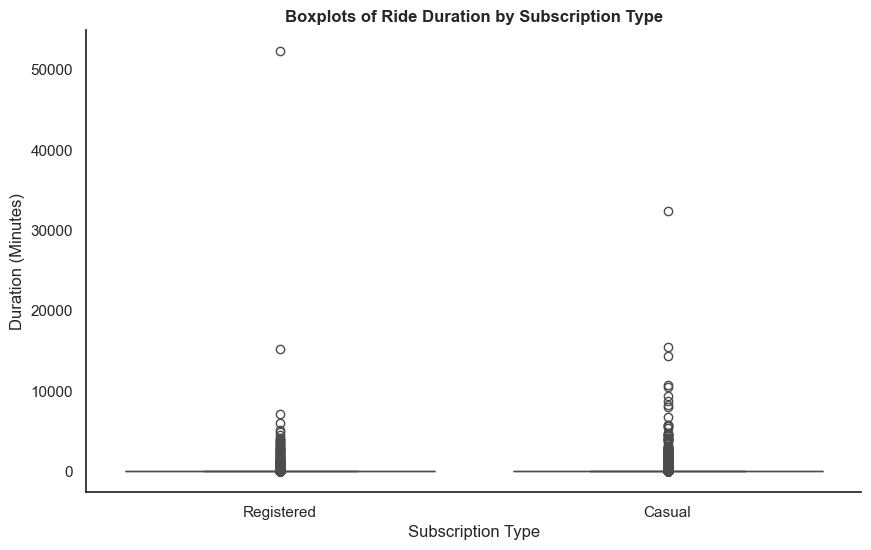

In [32]:
plt.figure(figsize= (10, 6))
sns.boxplot(data = rentaldata, x = "subscription_type", y = "duration_minutes")
plt.title("Boxplots of Ride Duration by Subscription Type")
plt.xlabel("Subscription Type")
plt.ylabel("Duration (Minutes)")
plt.show()

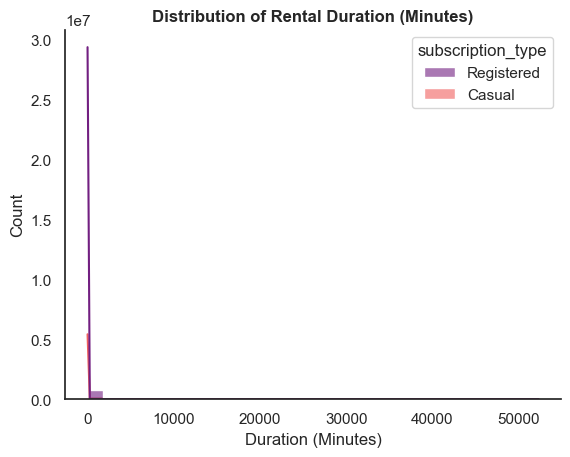

In [33]:
sns.histplot(data = rentaldata, x = "duration_minutes", hue = "subscription_type", alpha = 0.6, palette = "magma", bins = 30, kde = True)
plt.title("Distribution of Rental Duration (Minutes)")
plt.xlabel("Duration (Minutes)")
plt.show()

We see outliers having a heavy influence on the data. Let's filter out the outliers and look at those rentals that only lasted for up to 4 hours.

In [34]:
rental_subset = rentaldata[rentaldata["duration_minutes"] <= 240]

C:\Users\smith\AppData\Local\Temp\ipykernel_24868\76029088.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = rental_subset, x = "subscription_type", y = "duration_minutes", palette = "magma")


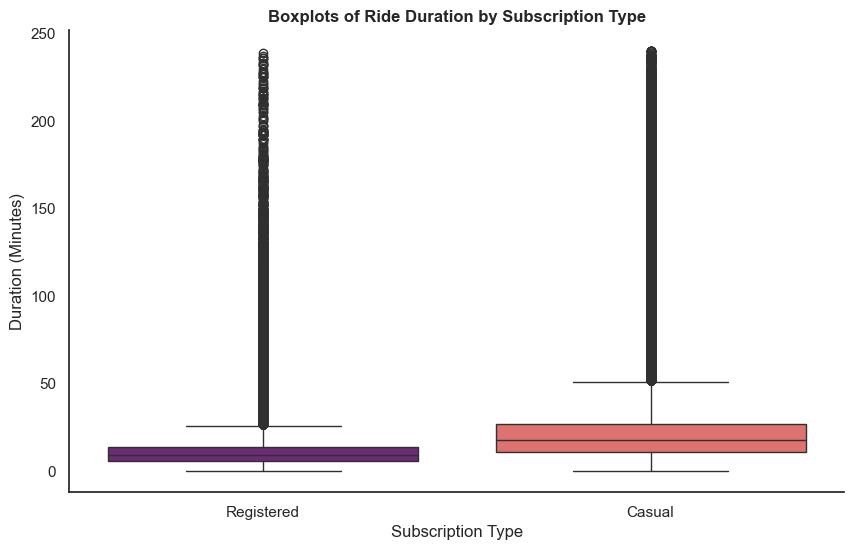

In [35]:
plt.figure(figsize= (10, 6))
sns.boxplot(data = rental_subset, x = "subscription_type", y = "duration_minutes", palette = "magma")
plt.title("Boxplots of Ride Duration by Subscription Type")
plt.xlabel("Subscription Type")
plt.ylabel("Duration (Minutes)")
plt.show()

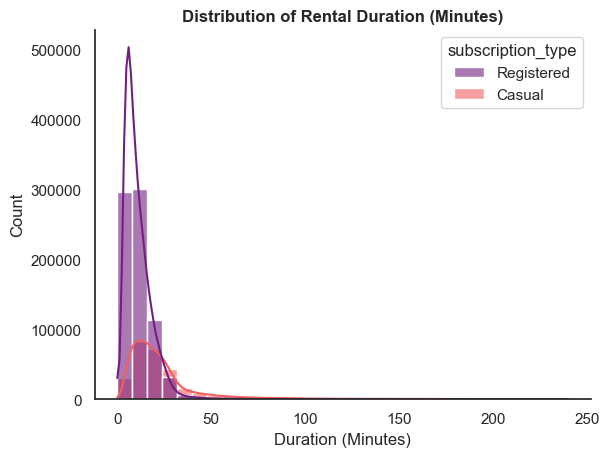

In [36]:
sns.histplot(data = rental_subset, x = "duration_minutes", hue = "subscription_type", alpha = 0.6, palette = "magma", bins = 30, kde = True)
plt.title("Distribution of Rental Duration (Minutes)")
plt.xlabel("Duration (Minutes)")
plt.show()

While we still have outliers influencing our distributions, we can see the data more clearly. It appears as though casual riders might have a slightly higher median riding time compared to registered users. Both types seem to demonstrate a somewhat similar distribution shape.

Let's take out all the outliers (based on IQR methodology) to see only those observations which are within a normal range.

In [37]:
# Calculate Quartiles (Q1 and Q3)
Q1 = rentaldata['duration_minutes'].quantile(0.25)
Q3 = rentaldata['duration_minutes'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
rentaldata_no_outliers = rentaldata[(rentaldata['duration_minutes'] >= lower_bound) & (rentaldata['duration_minutes'] <= upper_bound)]

C:\Users\smith\AppData\Local\Temp\ipykernel_24868\3919857600.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = rentaldata_no_outliers, x = "subscription_type", y = "duration_minutes", palette = "magma")


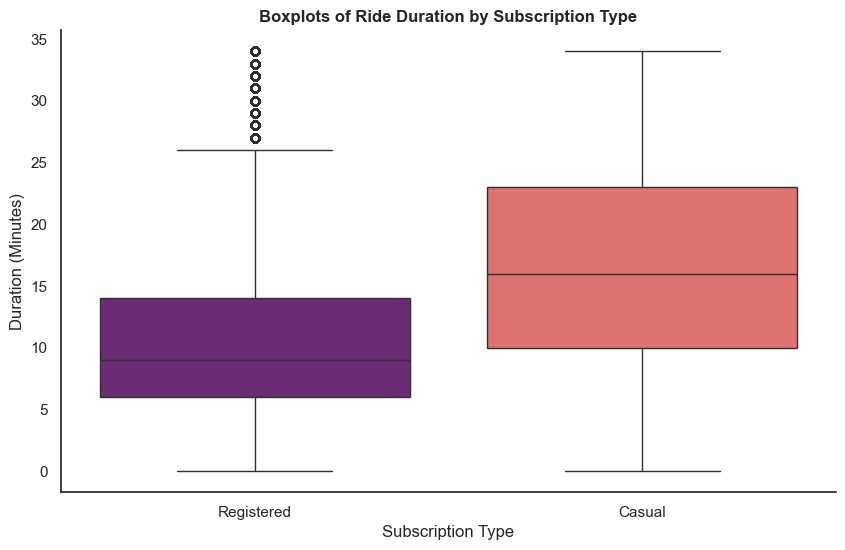

In [38]:
plt.figure(figsize= (10, 6))
sns.boxplot(data = rentaldata_no_outliers, x = "subscription_type", y = "duration_minutes", palette = "magma")
plt.title("Boxplots of Ride Duration by Subscription Type")
plt.xlabel("Subscription Type")
plt.ylabel("Duration (Minutes)")
plt.show()

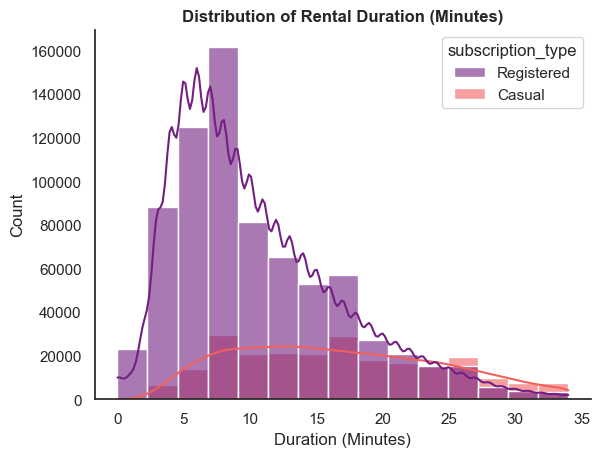

In [39]:
sns.histplot(data = rentaldata_no_outliers, x = "duration_minutes", hue = "subscription_type", alpha = 0.6, palette = "magma", bins = 15, kde = True)
plt.title("Distribution of Rental Duration (Minutes)")
plt.xlabel("Duration (Minutes)")
plt.show()

We can see more clearly that casual riders have a higher variability in their riding times, leading to a wider boxplot. We can also see from the distribution plot that while the registered riders have a peak riding time of around 7.5 minutes, casual riders don't have a certain preferred riding length and their time might vary.

### Usage Based on Subscription Type

Let's look at the total number of registered users vs casual users. Riders are likely to use the service more than once, however unique IDs for the rider is not available. The plot created will likely show a skew towards premium members, due to these users being more likely to use the service repeated times.

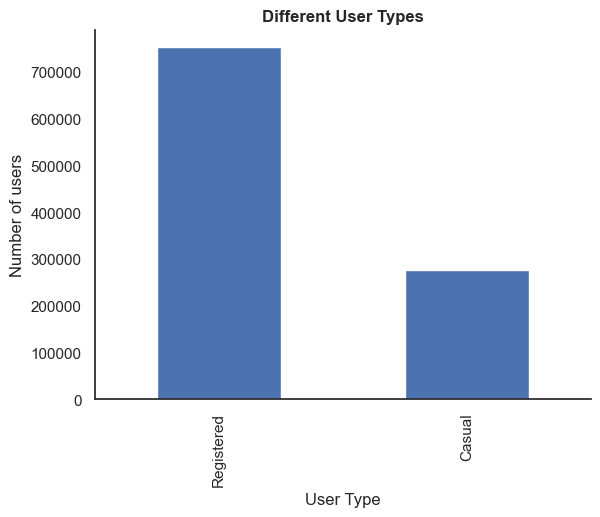

In [40]:
# Count number of users based on type
user_types = rentaldata["subscription_type"].value_counts()
# Create plot of users
user_types.plot(kind = "bar")
plt.title("Different User Types")
plt.xlabel("User Type")
plt.ylabel("Number of users")
plt.show()

As expected, the registered user counts show a much higher value.

### Popularity of Service by Hour

Let's next look at certain hours that a ride was started. We can determine when the peak hours are for the bike rental service.

In [41]:
# Extract hour and day of week for rentals
rentaldata["hour"] = rentaldata["start_date"].dt.hour
rentaldata["day_of_week"] = rentaldata["start_date"].dt.dayofweek # 0 = Monday; 6 = Sunday

# Create a column to categorize day of the week
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
rentaldata["day_of_week_name"] = rentaldata["day_of_week"].apply(lambda x: days[x])

Now, we can plot the most common hours of rental and separate it based on membership type.

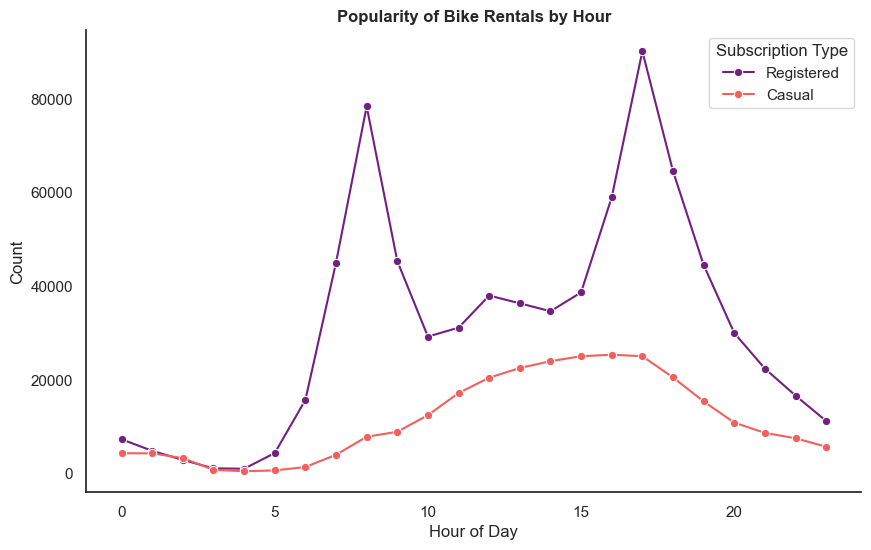

In [42]:
# Find the count per hour, by subscription type
count_per_hour = rentaldata.groupby(['hour', 'subscription_type']).size().reset_index(name='count')

# Customize colors to match subscription type colors in the rest of the charts
magma_colors = sns.color_palette('magma', n_colors=2)  # Assuming 2 user types

# Reorder colors for your categories (e.g., from 'magma' palette)
custom_palette = {'Registered': magma_colors[0], 'Casual': magma_colors[1]}

plt.figure(figsize=(10, 6))
sns.lineplot(data=count_per_hour, x='hour', y='count', hue = "subscription_type", hue_order=['Registered', 'Casual'], marker='o', palette = custom_palette)
plt.title("Popularity of Bike Rentals by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.legend(title = "Subscription Type")
plt.show()


We see a marked difference in distribution between rental hours and membership types. Registered members primarily rent bikes between 7 and 9 am, and between 4 and 6 pm. This matches standard working hours, so it is likely that these riders use the bikes to commute to work. We also see a decent amount of usage during the late morning and early afternoon. The usage drops off considerably in the evening (after 8 or 9 pm).

The casual riders have a more normal distribution of ride times. They start with low rental counts during the morning (6 am) and gradually increase in ridership until it peaks around 4 to 5 pm, then gradually drops down again.

Let's define some time frames and see the count of bike rentals in these frames.

In [43]:
def time_frame_category(hour):
    if 6 <= hour < 9:
        return "Early Morning"
    elif 9 <= hour < 12:
        return "Late Morning"
    elif 12 <= hour < 15:
        return "Early Afternoon"
    elif 15 <= hour < 18:
        return "Late Afternoon"
    elif 18 <= hour < 21:
        return "Early Evening"
    elif 21 <= hour < 24:
        return "Late Evening"
    else:
        return "Graveyard Hours"
    
rentaldata["time_frame"] = rentaldata["hour"].apply(time_frame_category)

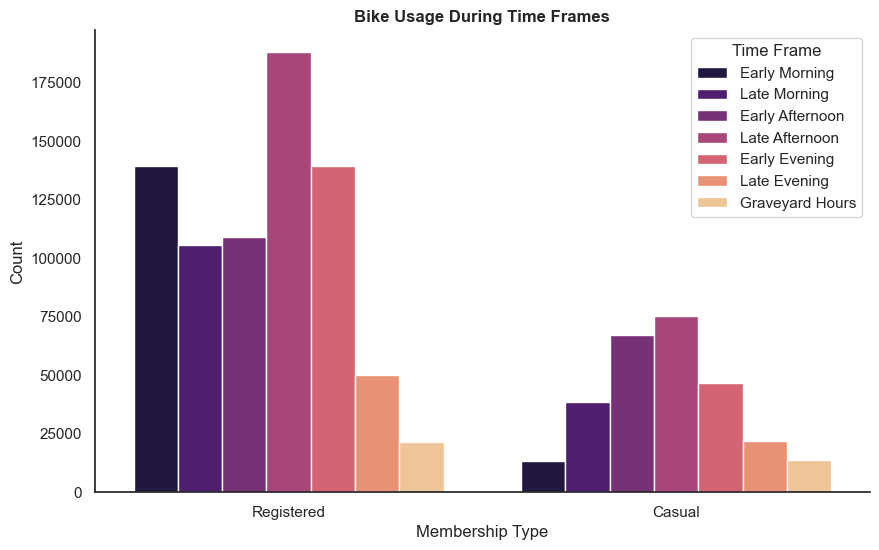

In [44]:
# Set up proper ordering for time frames
time_frame_order = ["Early Morning", "Late Morning", "Early Afternoon", "Late Afternoon", "Early Evening", "Late Evening", "Graveyard Hours"]

plt.figure(figsize= (10, 6))
sns.countplot(data = rentaldata, x = "subscription_type", hue = "time_frame", palette = "magma", hue_order= time_frame_order)
plt.title("Bike Usage During Time Frames")
plt.xlabel("Membership Type")
plt.ylabel("Count")
plt.legend(title = "Time Frame")
plt.show()

This helps us isolate certain time frames that riders use the service and help show the distribution of our rental services more.

### Popularity of Service by Day

Now, let's see if certain days of the week are more popular for riders.

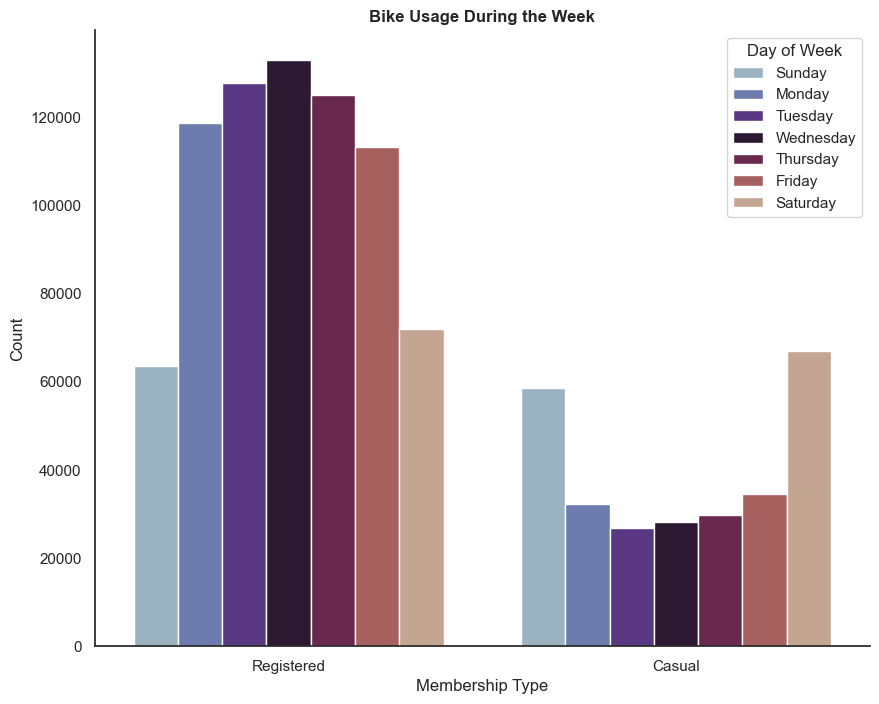

In [45]:
# Set up proper ordering for day of week names
dof_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

plt.figure(figsize= (10, 8))
sns.countplot(data = rentaldata, x = "subscription_type", hue = "day_of_week_name", palette = "twilight", hue_order = dof_order)
plt.title("Bike Usage During the Week")
plt.xlabel("Membership Type")
plt.ylabel("Count")
plt.legend(title = "Day of Week")
plt.show()

Here, we can see the popularity of the service based on the day of the week. It seems as though the registered users are active primarily through the weekdays (again, fitting the assumption that they use the service to commute to work). There is a slightly higher amount of usage on Wednesday as well. Their usage drops off on the weekend.

The casual users, on the other hand, tend to use the service more on the weekends. These might be for impromptu activities, socializing, or other spur of the moment events. 

Let's combine this section with the previous, and look at the most popular hour and day in conjunction.

First, let's look at registered members.

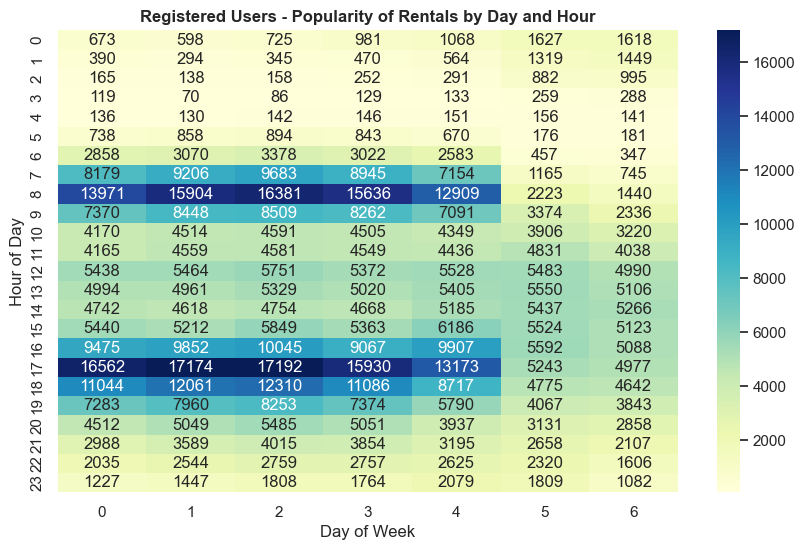

In [46]:
# Group by hour and day of week, then count occurrences
day_hour_rides = rentaldata[rentaldata["subscription_type"] == "Registered"].groupby(["hour", "day_of_week"]).size().unstack()

# Create heatmap to visualize most prominent times
plt.figure(figsize = (10, 6))
sns.heatmap(day_hour_rides, cmap = "YlGnBu", annot = True, fmt = "d", cbar = True)
plt.title("Registered Users - Popularity of Rentals by Day and Hour")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.show()

We can see fairly consistent results here. The highest counts are for 5 pm on Tuesday and Wednesday. They use the bikes slightly more in the evening compared to the morning, however the difference between these values isn't very marked. We do see a slight dropoff in usage overall on Friday. When they use the bikes on the weekends, it tends to be in the afternoon (12 pm to 5 pm), however these counts aren't nearly as high as their usage during the weekdays.

Now let's look at casual members.

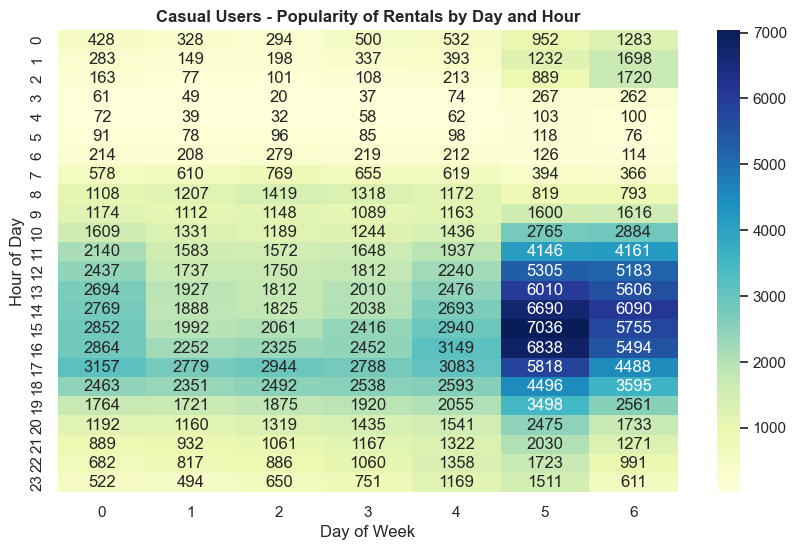

In [47]:
# Group by hour and day of week, then count occurrences
day_hour_rides = rentaldata[rentaldata["subscription_type"] == "Casual"].groupby(["hour", "day_of_week"]).size().unstack()

# Create heatmap to visualize most prominent times
plt.figure(figsize = (10, 6))
sns.heatmap(day_hour_rides, cmap = "YlGnBu", annot = True, fmt = "d", cbar = True)
plt.title("Casual Users - Popularity of Rentals by Day and Hour")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.show()

We see medium usage throughout the late morning and afternoon on Monday for casual riders. Tuesday and Wednesday are fairly low overall, with just some usage in the late afternoon. Friday has medium usage as well throughout the afternoon. But with casual users, we can quickly see their high usage on weekends. Saturday and Sunday both show high usage counts, especially during the afternoon and early evening. The highest point comes in at Satuday at 3 pm. 

Knowing when our users (both registerd and casual) will tend to desire rentals can help us plan our stations effectively.

### Popularity of Service by Month

We can also look at which months are more popular for rentals.

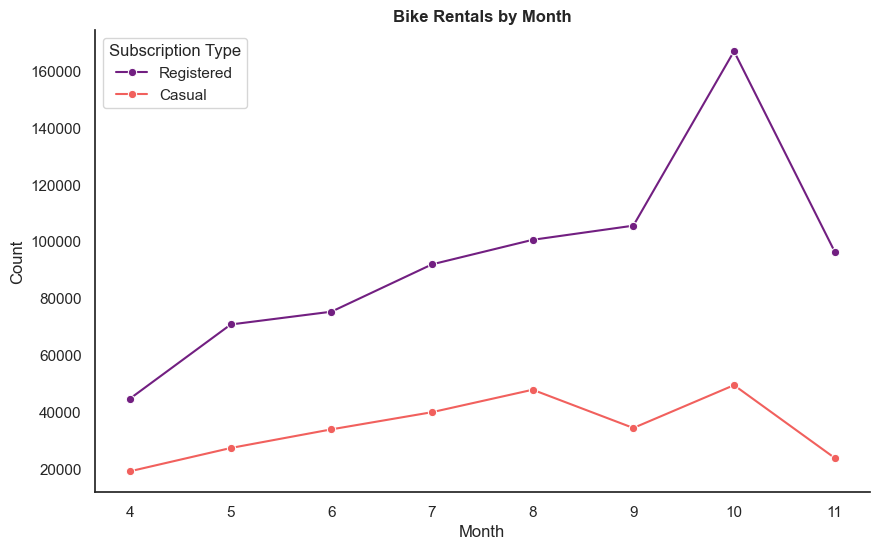

In [48]:
rentaldata["month"] = rentaldata["start_date"].dt.month

count_per_month = rentaldata.groupby(['month', 'subscription_type']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.lineplot(data=count_per_month, x='month', y='count', hue = "subscription_type", hue_order=['Registered', 'Casual'], marker='o', palette = custom_palette)
plt.title("Bike Rentals by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(title = "Subscription Type")
plt.show()


Interestingly, there are more rentals in October than any other month. However, this doesn't take into consideration the unique years that the data contains. Let's look at it by Month and Year.

In [49]:
# Extract year and month separately
rentaldata['year'] = rentaldata['start_date'].dt.year
rentaldata['month'] = rentaldata['start_date'].dt.month

rentaldata['year_month'] = rentaldata['year'].astype(str) + '-' + rentaldata['month'].astype(str).str.zfill(2)

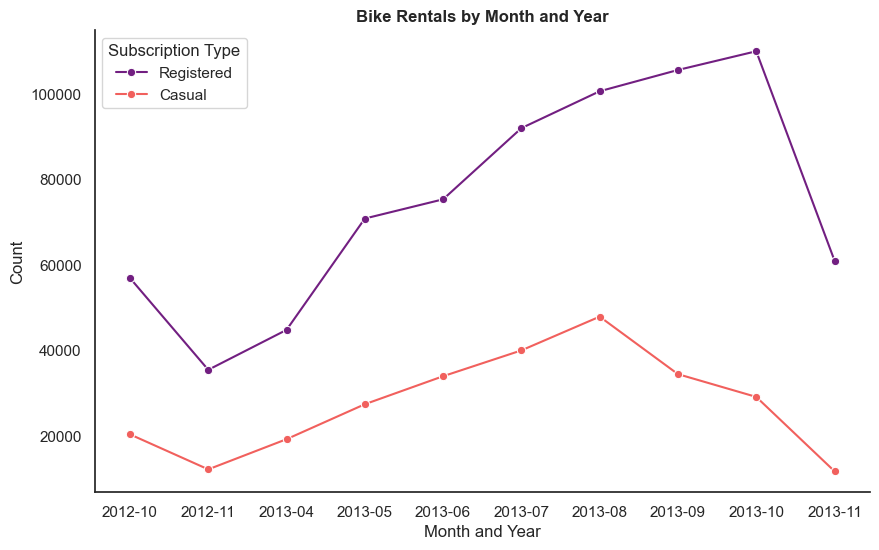

In [50]:
count_per_month = rentaldata.groupby(['year_month', 'subscription_type']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.lineplot(data=count_per_month, x='year_month', y='count', hue = "subscription_type", hue_order=['Registered', 'Casual'], marker='o', palette = custom_palette)
plt.title("Bike Rentals by Month and Year")
plt.xlabel("Month and Year")
plt.ylabel("Count")
plt.legend(title = "Subscription Type")
plt.show()


Now we can see a much more accurate timeline of our rentals. For casual users, rentals increased from April 2013 and peaked in August of 2013. Registerd users, however, peaked in October of 2013. This seems to indicate that registered users will continue to use the service even when the months approach the Fall and Winter seasons, although we do see a large dropoff in usage in November.

### Top Stations

Let's see which stations are most popular to start and end at.

In [51]:
rentaldata.rename(columns={'id': 'rental_id'}, inplace=True)

In [52]:
stationdata_subset = stationdata[["id", "station"]]

rentaldata = pd.merge(rentaldata, stationdata_subset, left_on='start_station', right_on='id', how='left')
rentaldata.rename(columns={'station': 'start_station_name'}, inplace=True)
rentaldata.drop('id', axis=1, inplace=True)

rentaldata = pd.merge(rentaldata, stationdata_subset, left_on='end_station', right_on='id', how='left')
rentaldata.rename(columns={'station': 'end_station_name'}, inplace=True)
rentaldata.drop('id', axis=1, inplace=True)

Let's look at how many rentals occur per day.

In [53]:
rentaldata['start_date_floor'] = rentaldata['start_date'].dt.floor('D')

daily_rentals = rentaldata.groupby('start_date_floor').size()
# average rentals per day
print(daily_rentals.mean())

3409.569536423841


An average of 3410 bikes are rented each day. Let's see how many bikes are rented per station each day.

In [60]:
mean_occurrences_per_day_per_station = rentaldata.groupby(['start_station_name', 'start_date_floor']).size().groupby('start_station_name').mean()

# Average rentals per station per day
print(mean_occurrences_per_day_per_station.mean())
print(mean_occurrences_per_day_per_station.sort_values(ascending=False).head(10))
print(mean_occurrences_per_day_per_station.sort_values(ascending=False).tail(10))

28.37863404422235
start_station_name
MIT at Mass Ave / Amherst St                            101.304636
South Station - 700 Atlantic Ave.                       100.448161
Boston Public Library - 700 Boylston St.                 77.505455
Beacon St / Mass Ave                                     77.375000
Charles Circle - Charles St. at Cambridge St.            77.235495
TD Garden - Causeway at Portal Park #1                   67.824219
Harvard Square at Mass Ave/ Dunster                      67.415282
Kendall T at Main St                                     62.539286
Lafayette Square at Mass Ave / Main St / Columbia St     62.523810
Kenmore Sq / Comm Ave                                    62.134483
dtype: float64
start_station_name
South Bay Plaza                            4.718750
Summer St at Cutter St                     4.583333
Hayes Square at Vine St.                   4.415094
JFK / UMASS Station                        4.383459
Dudley Square                              4.096296

The overall average rentals per station per day is 28. Some stations have much higher average rentals. Others have much lower. We can also look at the average number of bike docks per station.

In [63]:
print(stationdata['nb_docks'].mean())
print(stationdata['nb_docks'].min())
print(stationdata['nb_docks'].max())

17.592307692307692
11.0
47.0


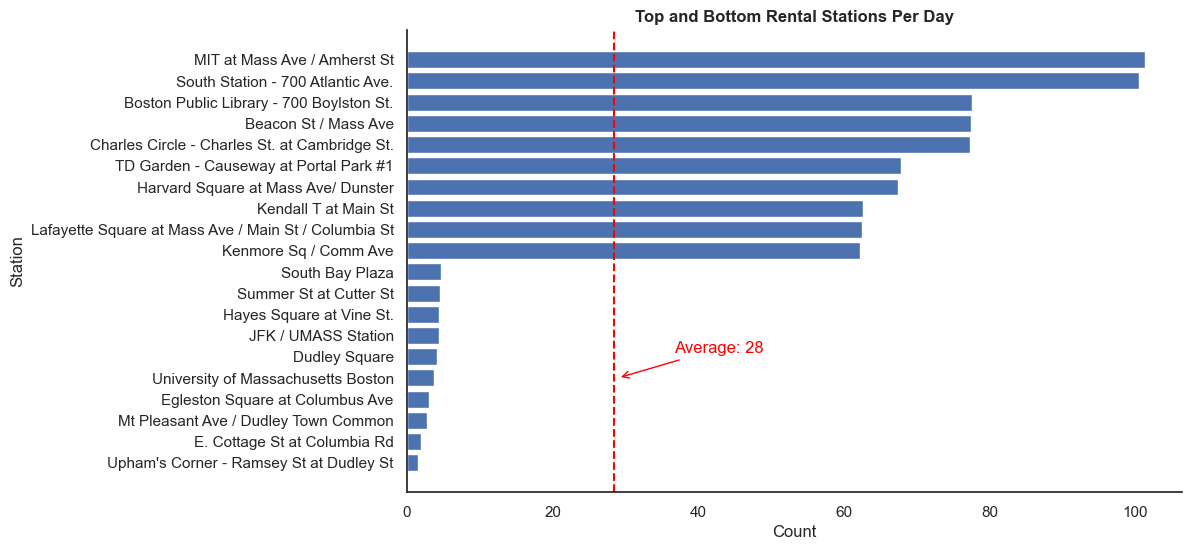

In [72]:
top_station_rentals = mean_occurrences_per_day_per_station.sort_values(ascending=False).head(10)
bottom_station_rentals = mean_occurrences_per_day_per_station.sort_values(ascending=False).tail(10)
top_bottom_station_rentals = pd.concat([top_station_rentals, bottom_station_rentals])

plt.figure(figsize= (10, 6))
plt.barh(top_bottom_station_rentals.index, top_bottom_station_rentals.values)
plt.axvline(x=mean_occurrences_per_day_per_station.mean(), color='red', linestyle='--')
plt.annotate('Average: 28',  # Average rentals per day per station
             xy=(29, 15),  # Position of the point to annotate (x, y)
             xytext=(40, 18),  # Position of the text (x, y) with an offset
             textcoords='offset points',  # Text position relative to xy point
             arrowprops=dict(arrowstyle='->', color='red'),
             color = "red")  # Arrow style
plt.title("Top and Bottom Rental Stations Per Day")
plt.xlabel("Count")
plt.ylabel("Station")
plt.gca().invert_yaxis()
plt.show()

Here, we can see that some stations have more docks than their are rented bikes on a daily basis. Other stations have much higher average rentals per day than their are docks. While we can assume that these popular stations will also have a high number of dropoffs from users, we also need to keep an eye on them to make sure they are properly stocked up.

Let's see these stations with high and low rentals per day.

In [73]:
top_10_start = rentaldata["start_station_name"].value_counts().head(10)
print(top_10_start)

start_station_name
MIT at Mass Ave / Amherst St                            30594
South Station - 700 Atlantic Ave.                       30034
Beacon St / Mass Ave                                    22903
Charles Circle - Charles St. at Cambridge St.           22630
Boston Public Library - 700 Boylston St.                21314
Harvard Square at Mass Ave/ Dunster                     20292
Back Bay / South End Station                            18461
Lafayette Square at Mass Ave / Main St / Columbia St    18382
Kenmore Sq / Comm Ave                                   18019
Kendall T at Main St                                    17511
Name: count, dtype: int64


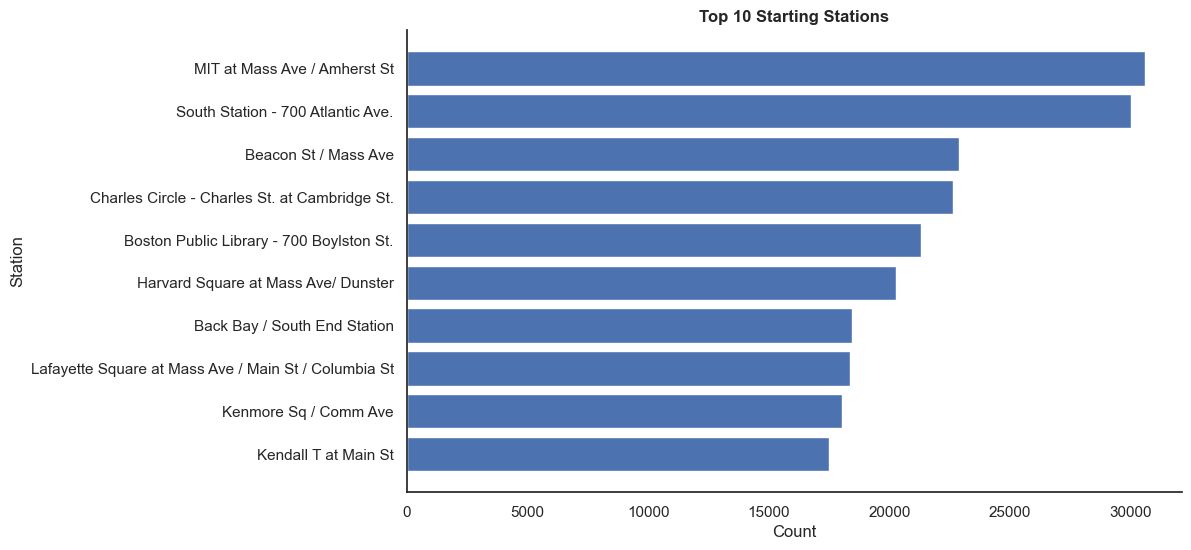

In [74]:
plt.figure(figsize= (10, 6))
plt.barh(top_10_start.index, top_10_start.values)
plt.title("Top 10 Starting Stations")
plt.xlabel("Count")
plt.ylabel("Station")
plt.gca().invert_yaxis()
plt.show()

In [75]:
top_10_end = rentaldata["end_station_name"].value_counts().head(10)
print(top_10_end)

end_station_name
MIT at Mass Ave / Amherst St                            31396
South Station - 700 Atlantic Ave.                       29760
Harvard Square at Mass Ave/ Dunster                     22965
Boston Public Library - 700 Boylston St.                22136
Charles Circle - Charles St. at Cambridge St.           21622
Beacon St / Mass Ave                                    20816
TD Garden - Causeway at Portal Park #1                  19119
Lafayette Square at Mass Ave / Main St / Columbia St    18980
Kenmore Sq / Comm Ave                                   18747
Boylston St. at Arlington St.                           18058
Name: count, dtype: int64


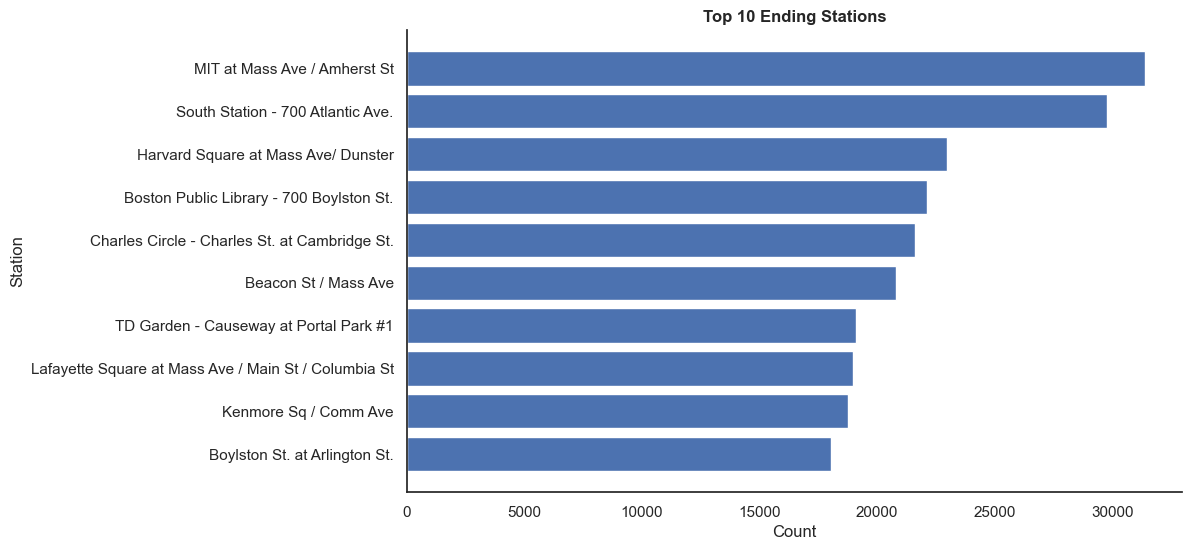

In [76]:
plt.figure(figsize= (10, 6))
plt.barh(top_10_end.index, top_10_end.values)
plt.title("Top 10 Ending Stations")
plt.xlabel("Count")
plt.ylabel("Station")
plt.gca().invert_yaxis()
plt.show()

Based on this, we can see a large amount of trips are both started and ended at MIT and South Station.

Let's see if there are common routes that are taken.

In [77]:
# Count occurrences of each start-end station pairing
pair_counts = rentaldata.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='pair_count')
most_common_pairings = pair_counts.sort_values(by='pair_count', ascending=False).iloc[0:10]

print(most_common_pairings)

                            start_station_name  \
1020                      Beacon St / Mass Ave   
8705              MIT at Mass Ave / Amherst St   
7718                     Kenmore Sq / Comm Ave   
8767              MIT at Mass Ave / Amherst St   
8211               Lewis Wharf - Atlantic Ave.   
11414        South Station - 700 Atlantic Ave.   
8775              MIT at Mass Ave / Amherst St   
11779   TD Garden - Causeway at Portal Park #1   
8766              MIT at Mass Ave / Amherst St   
8653   MIT Stata Center at Vassar St / Main St   

                              end_station_name  pair_count  
1020              MIT at Mass Ave / Amherst St        4747  
8705                      Beacon St / Mass Ave        4610  
7718              MIT at Mass Ave / Amherst St        2539  
8767                     Kenmore Sq / Comm Ave        2370  
8211         South Station - 700 Atlantic Ave.        2025  
11414              Lewis Wharf - Atlantic Ave.        1911  
8775   MIT Stata Cente

From this, we can see common routes that riders take. We can also analyze what these riders intend with their service and optimize these routes for potential new customers.

### Top Stations by Duration

Let's also see if riders starting from a certain station have higher ride times.

In [78]:
top_duration = rentaldata.groupby("start_station_name")["duration_minutes"].mean().sort_values(ascending= False).head(5)
bottom_duration = rentaldata.groupby("start_station_name")["duration_minutes"].mean().sort_values(ascending= False).tail(5)

print(top_duration)
print(bottom_duration)

start_station_name
E. Cottage St at Columbia Rd           138.576087
University of Massachusetts Boston      43.236813
JFK / UMASS Station                     32.227273
New Balance - Guest St. at Life St.     29.111439
Dudley Square                           24.316456
Name: duration_minutes, dtype: float64
start_station_name
New Balance Store - Boylston at Dartmouth    11.658654
Washington St. at Rutland St.                11.643581
Columbus Ave. at Mass. Ave.                  11.243425
Tremont St / W Newton St                     11.238081
Teele Square at 239 Holland St               11.182540
Name: duration_minutes, dtype: float64


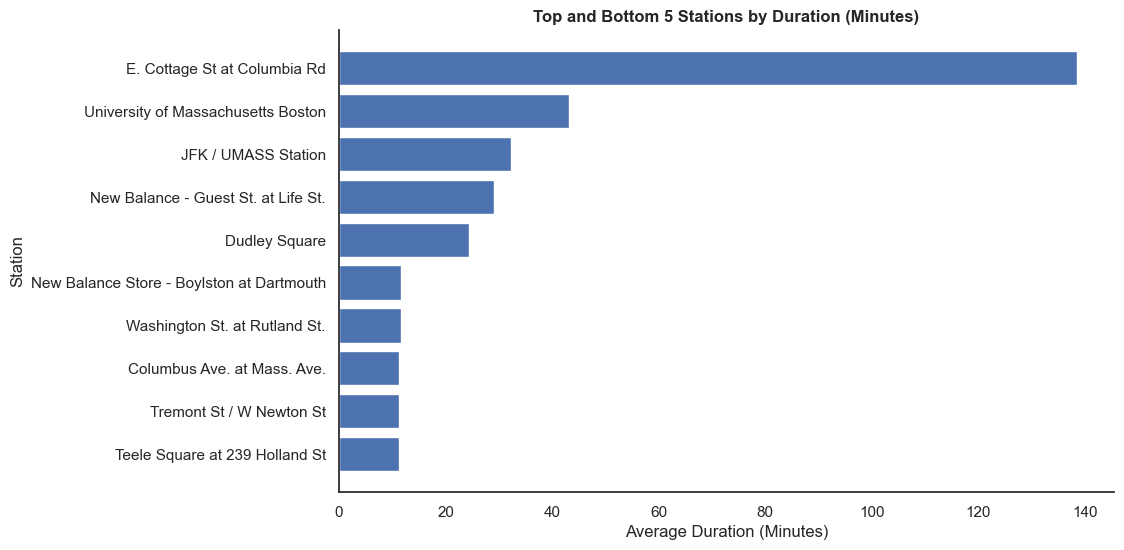

In [79]:
top_bottom_duration = pd.concat([top_duration, bottom_duration])

plt.figure(figsize= (10, 6))
plt.barh(top_bottom_duration.index, top_bottom_duration.values)
plt.title("Top and Bottom 5 Stations by Duration (Minutes)")
plt.xlabel("Average Duration (Minutes)")
plt.ylabel("Station")
plt.gca().invert_yaxis()
sns.despine()
plt.show()

While the bottom 5 stations have a similar average duration (around 11 minutes), the top 5 stations have a much higher variance. The top station, in particular, has an average duration of around 138 minutes.

We could also look at boxplots for each starting station to see if any stations seem to stand out in their median rental times. Let's use the previous subset where we only look at rides under 4 hours.

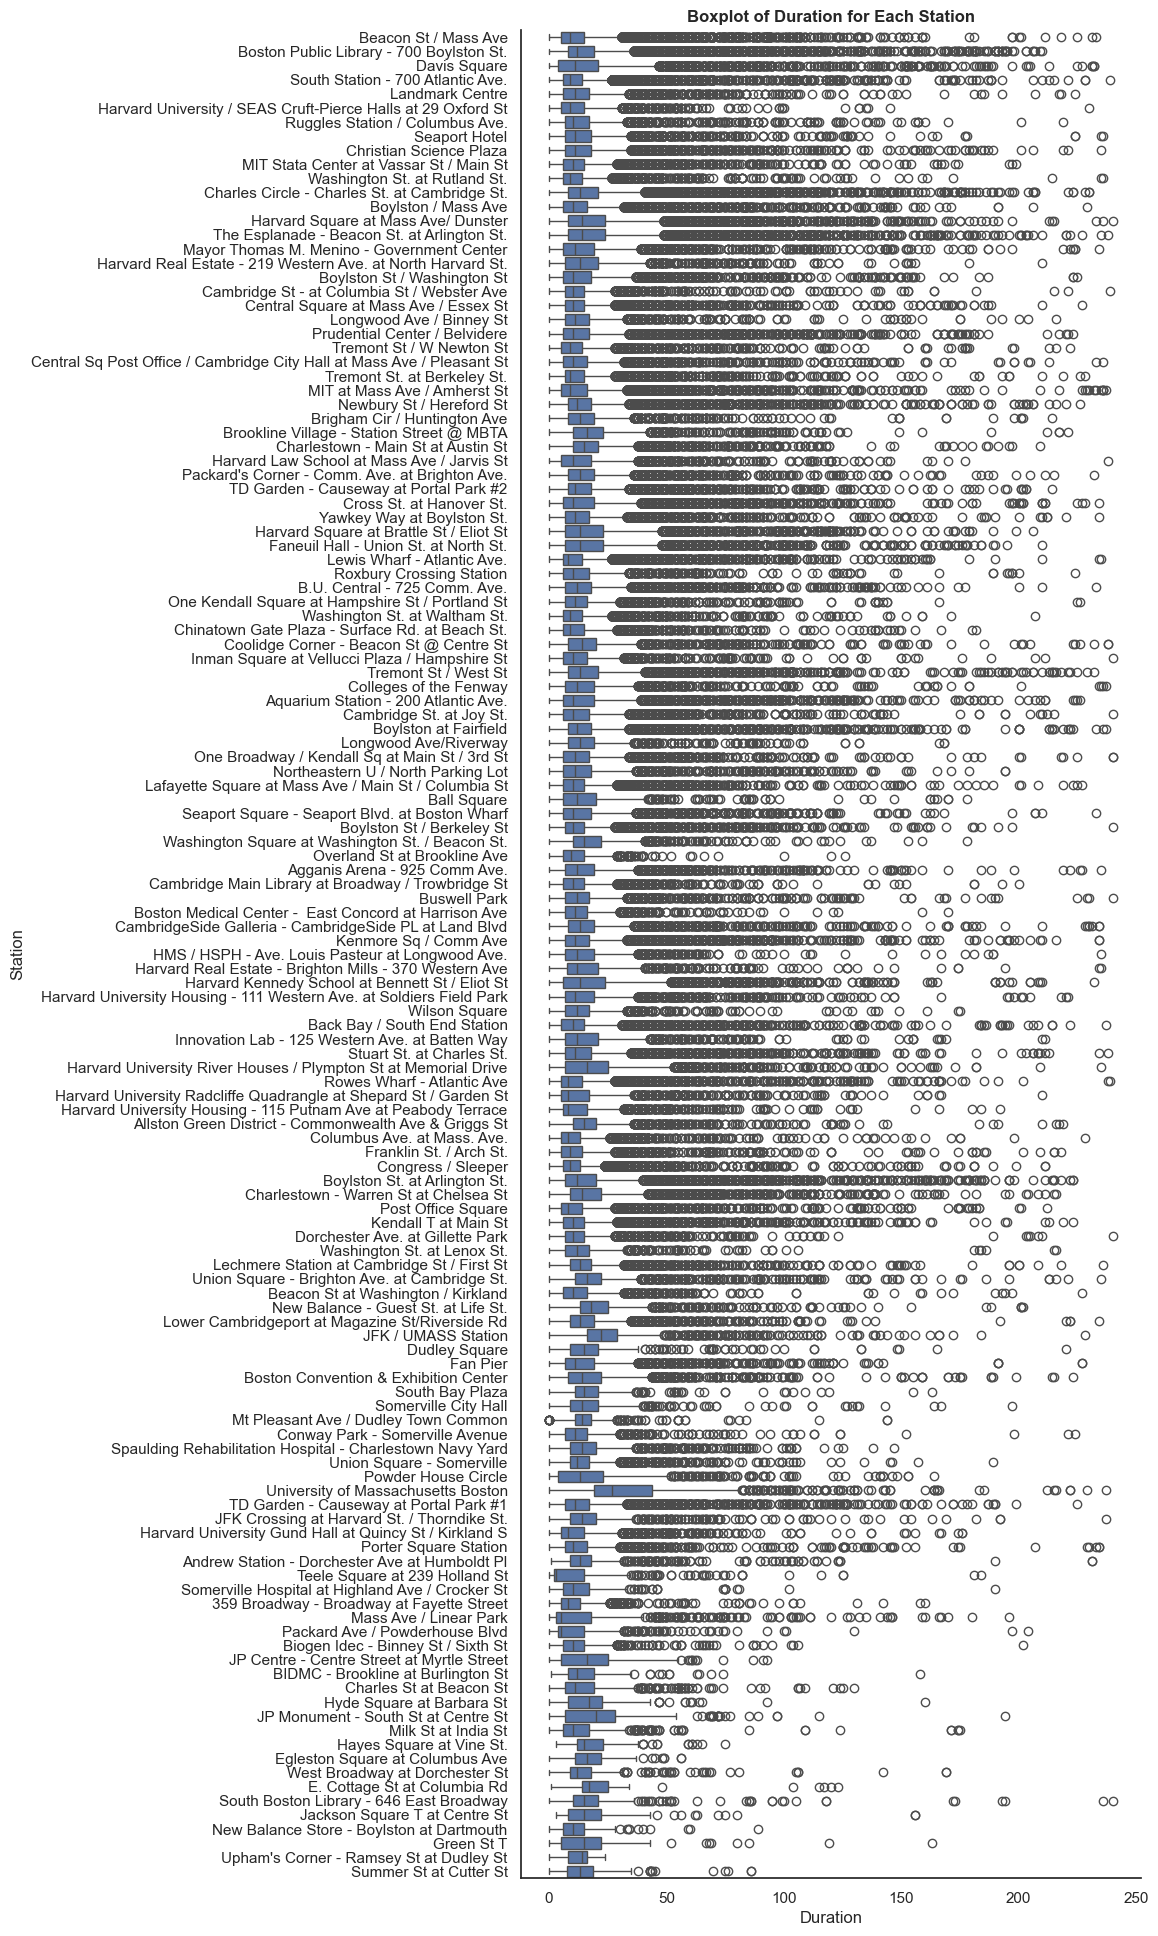

In [80]:
rental_subset = rentaldata[rentaldata["duration_minutes"] <= 240]

plt.figure(figsize=(8, 24))
sns.boxplot(data=rental_subset, y='start_station_name', x='duration_minutes')
plt.title('Boxplot of Duration for Each Station')
plt.xlabel('Duration')
plt.ylabel('Station')
plt.show()

While the output is quite busy, we can still look for some patterns. Many of the stations have a consistent distribution of riding times. But some show wide or narrow variance in riding times. 

For instance, "Congress / Sleeper" has a very narrow plot, indicating that riders here tend to ride generally the same amount without much variation. 

Others, like "University of Massachusetts Boston" has a very wide range, indicating that riders starting at this station are not nearly as predictable in how often they will rent for. This station also has a high median compared to the other stations.

We can also look at stations like "Summer St at Cutter St" and see that there are very few outliers with these rides. We can expect that there won't be very inflated rental times when riders start at stations with this sort of distribution.

### Total Ride Per Bike

Let's see if certain bikes are ridden more often than others. This can help the company maintain these bikes and rotate them out if necessary.

In [81]:
bike_count = rentaldata["bike_nr"].value_counts()
bike_count = pd.DataFrame(bike_count)

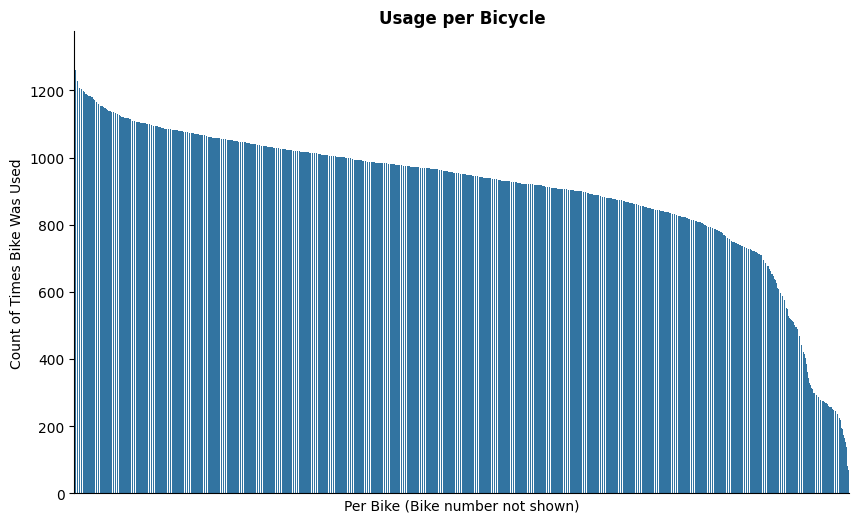

In [82]:
sns.reset_defaults()
plt.figure(figsize= (10, 6))
sns.barplot(data = bike_count, x = "bike_nr", y = "count")
plt.title("Usage per Bicycle", fontweight = "bold")
sns.despine()
plt.xlabel("Per Bike (Bike number not shown)")
plt.ylabel("Count of Times Bike Was Used")
plt.xticks([])
plt.show()

We see a fairly even distribution, without too many bikes being used too often. However, if we wanted to isolate those bikes that have been used many times (on the far left of the chart), we could identify them. Those bikes which haven't been used as often (on the far right) could be rotated in to stations that have high rentals.

In [83]:
top_bikes = bike_count.head(10)
print(top_bikes)

         count
bike_nr       
T01307    1310
T01296    1261
T01035    1259
T01416    1247
T01193    1227
T01089    1222
T01220    1215
T01230    1208
T01058    1207
T01006    1206


These 10 bikes have been ridden the most, so it is best for them to be maintenanced if they haven't already been recently.

In [84]:
bottom_bikes = bike_count.tail(10)
print(bottom_bikes)

         count
bike_nr       
B00658     181
T01067     173
B00207     166
B00641     165
B00630     153
B00313     138
B00162     136
B00624      81
B01491      69
B01482      58


These 10 bikes have not been used as much, so they are prime candidates for swapping into highly active stations.

### Average and Total Duration Per Bike

Another thing we can look at is the average duration of riding time each bike has had. This can supplement the previous section about how often a bike is used and help allocate resources to help maintain them.

In [85]:
bike_duration = rentaldata.groupby("bike_nr")["duration_minutes"].mean().sort_values(ascending = False)
bike_duration = pd.DataFrame(bike_duration)

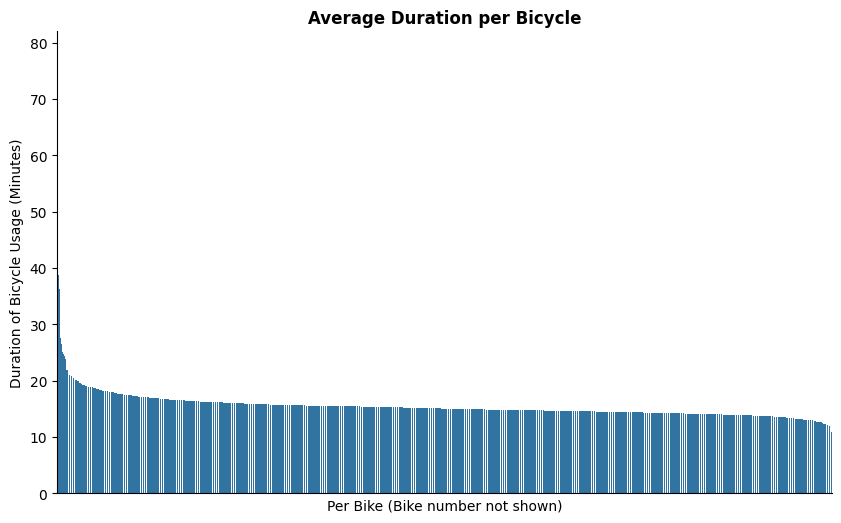

In [86]:
sns.reset_defaults()
plt.figure(figsize= (10, 6))
sns.barplot(data = bike_duration, x = "bike_nr", y = "duration_minutes")
plt.title("Average Duration per Bicycle", fontweight = "bold")
sns.despine()
plt.xlabel("Per Bike (Bike number not shown)")
plt.ylabel("Duration of Bicycle Usage (Minutes)")
plt.xticks([])
plt.show()

Again, we get a fairly average distribution here. Not too many bikes have had high average riding times. However, we still might want to identify the top and bottom bikes (per average duration) and keep this in mind for our rotation and maintenance.

In [87]:
print("Top Average Duration Per Bike:")
print(bike_duration.head(10))
print("Bottom Average Duration Per Bike:")
print(bike_duration.tail(10))

Top Average Duration Per Bike:
         duration_minutes
bike_nr                  
B00050          78.091018
B00411          52.323177
B00395          38.816446
B00132          36.295591
T01033          31.457589
B00248          27.521739
B00266          26.477895
T01186          25.919414
B00333          25.022173
B00656          24.738994
Bottom Average Duration Per Bike:
         duration_minutes
bike_nr                  
B01489          12.241611
B00652          12.239130
B00630          12.235294
A07815          12.092593
B00647          11.993197
B00649          11.957198
B00671          11.955782
A07811          11.909449
B00313          11.768116
A07810          10.835341


Seeing this output, we can easily see that although most bikes seem to have a fairly normal average duration, certain bikes (such as bike number B00050) have a high average duration and might require some extra resources.

We can also look at the total duration a bike has been rented for.

In [88]:
bike_duration_total = rentaldata.groupby("bike_nr")["duration_minutes"].sum().sort_values(ascending = False)
bike_duration_total = pd.DataFrame(bike_duration_total)

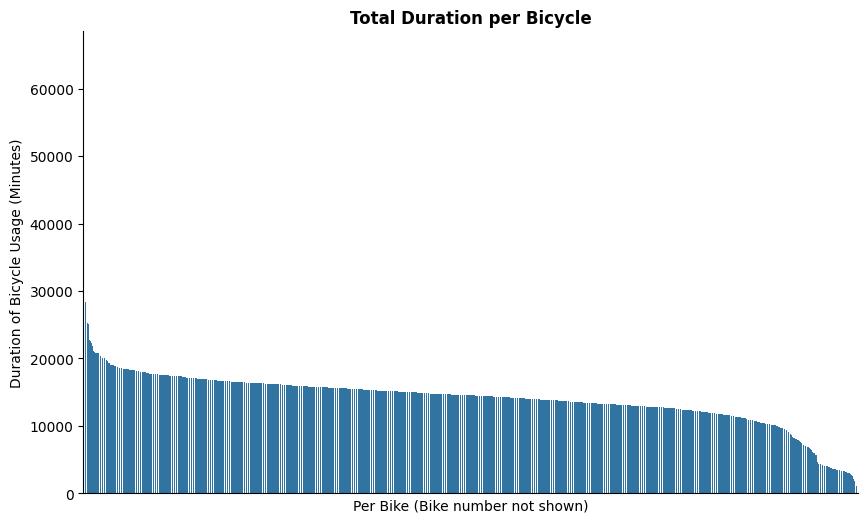

In [89]:
sns.reset_defaults()
plt.figure(figsize= (10, 6))
sns.barplot(data = bike_duration_total, x = "bike_nr", y = "duration_minutes")
plt.title("Total Duration per Bicycle", fontweight = "bold")
sns.despine()
plt.xlabel("Per Bike (Bike number not shown)")
plt.ylabel("Duration of Bicycle Usage (Minutes)")
plt.xticks([])
plt.show()

This gives a more overall view of how many minutes each bicycle has been used for. The distribution is no longer as normal, and we can see that certain bikes have been used for far more or far less time.

In [90]:
print("Top Overall Duration Per Bike:")
print(bike_duration_total.head(10))
print("Bottom Overall Duration Per Bike:")
print(bike_duration_total.tail(10))

Top Overall Duration Per Bike:
         duration_minutes
bike_nr                  
B00050            65206.0
B00411            48085.0
B00132            36223.0
T01186            28304.0
T01033            28186.0
B00395            26434.0
B00248            25320.0
B00266            25154.0
B00270            24027.0
B00522            22696.0
Bottom Overall Duration Per Bike:
         duration_minutes
bike_nr                  
A07810             2698.0
T01067             2529.0
B00207             2311.0
B00641             2161.0
B00630             1872.0
B00162             1762.0
B00313             1624.0
B00624             1119.0
B01491             1053.0
B01482              886.0


Looking at the top and bottom bikes by overall rental time, we see that a familiar bike number. Bike B00050 is at the top again. This sounds like a good time to check the condition of this bike.

# Predicting Bike Rental Time

In [91]:
# Setting up plot styles
sns.set_theme()
sns.set_style("white")

# Update default rc settings to remove top and right spines
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})

# Update default rc settings to set title font weight to 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

Now, let's see if we can predict what the rental time will be for a bike.

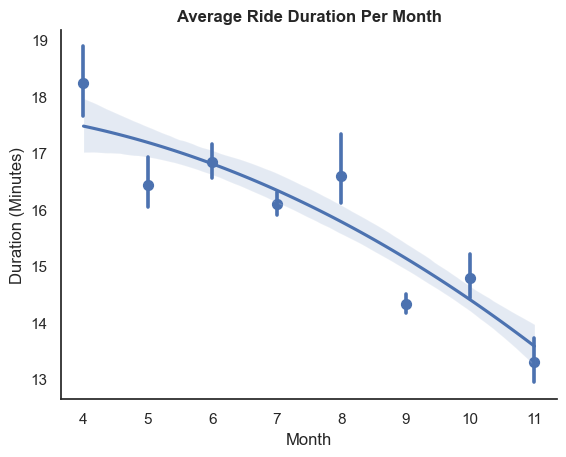

In [92]:
sns.regplot(data = rentaldata, x = "month", y = "duration_minutes", 
            x_estimator = np.mean, order = 2)
plt.title("Average Ride Duration Per Month")
plt.xlabel("Month")
plt.ylabel("Duration (Minutes)")
plt.show()

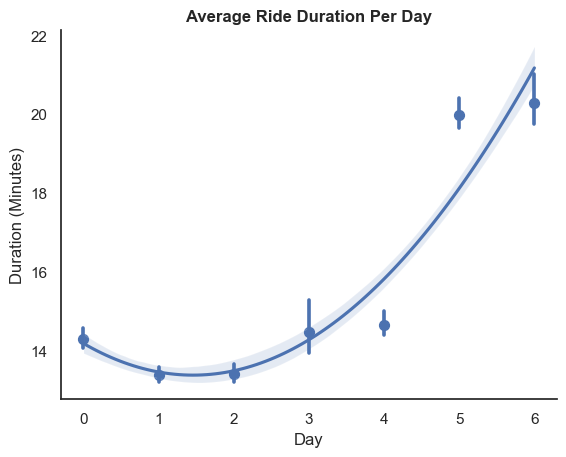

In [105]:
sns.regplot(data = rentaldata, x = "day_of_week", y = "duration_minutes", 
            x_estimator = np.mean, order = 2)
plt.title("Average Ride Duration Per Day")
plt.xlabel("Day")
plt.ylabel("Duration (Minutes)")
plt.show()

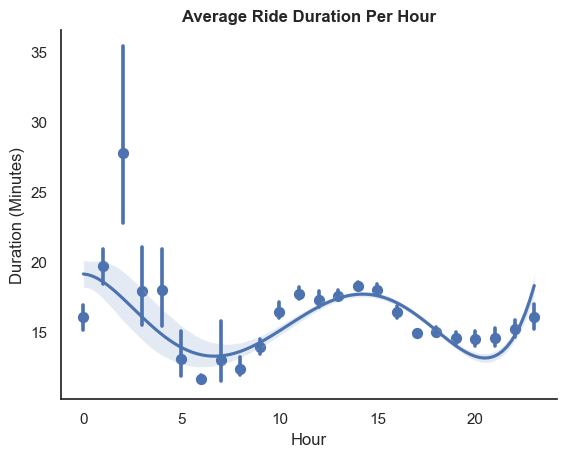

In [106]:
sns.regplot(data = rentaldata, x = "hour", y = "duration_minutes", 
            x_estimator = np.mean, order = 5)
plt.title("Average Ride Duration Per Hour")
plt.xlabel("Hour")
plt.ylabel("Duration (Minutes)")
plt.show()

This isn't a perfectly normal relationship, but we can see that average trip duration starts high in the beginning of the year and drops considerably between September through November. We can also see the trend line throughout days of the week and hours of the day.

Because most of our variables are categorical, we cannot easily look at a pairplot or correlation matrix for them. So instead, let's run these variables through a regression and try to predict the ride duration. We will also look at those rides that are maximum of 60 minutes, in order to get rid of the influence of heavy outliers.

In [93]:
rentaldata_1hour = rentaldata[(rentaldata['duration_minutes'] <= 60)]

rentaldata_1hour['start_station'] = rentaldata_1hour['start_station'].astype('category')
rentaldata_1hour['subscription_type'] = rentaldata_1hour['subscription_type'].astype('category')
rentaldata_1hour['gender'] = rentaldata_1hour['gender'].astype('category')
rentaldata_1hour['zip_code'] = rentaldata_1hour['zip_code'].astype('category')
rentaldata_1hour['hour'] = rentaldata_1hour['hour'].astype('category')
rentaldata_1hour['day_of_week'] = rentaldata_1hour['day_of_week'].astype('category')
rentaldata_1hour['month'] = rentaldata_1hour['month'].astype('category')


C:\Users\smith\AppData\Local\Temp\ipykernel_24868\984606824.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentaldata_1hour['start_station'] = rentaldata_1hour['start_station'].astype('category')
C:\Users\smith\AppData\Local\Temp\ipykernel_24868\984606824.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentaldata_1hour['subscription_type'] = rentaldata_1hour['subscription_type'].astype('category')
C:\Users\smith\AppData\Local\Temp\ipykernel_24868\984606824.py:5: SettingWithCopyWarning: 
A value is 

In [94]:
X = rentaldata_1hour[['start_station', 'subscription_type', 'gender', 'hour', 'day_of_week', 'month']]  # Independent variables
y = rentaldata_1hour['duration_minutes']  # Dependent variable

# Convert categorical columns to numerical using one-hot encoding
X = pd.get_dummies(X)

# Splitting the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=62)

# Initializing and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting the target variable on the test set
y_pred = model.predict(X_test)

In [95]:
# Evaluate model performance (R-squared score)
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

R-squared: 0.20820820259714223


In [96]:
# Coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Printing coefficients and intercept
print("Intercept:", intercept)
print("Coefficients:")
for feature, coef in zip(X.columns, coefficients):
    print(feature, ':', coef)

Intercept: -196927030712.23462
Coefficients:
start_station_3 : 933699413.7888587
start_station_4 : 933699412.3546534
start_station_5 : 933699412.9940567
start_station_6 : 933699413.0022092
start_station_7 : 933699413.6794848
start_station_8 : 933699416.838615
start_station_9 : 933699413.8488812
start_station_10 : 933699412.9600406
start_station_11 : 933699413.5730424
start_station_12 : 933699413.0219615
start_station_14 : 933699414.4141378
start_station_15 : 933699415.3285353
start_station_16 : 933699412.652175
start_station_17 : 933699413.901613
start_station_18 : 933699414.7496738
start_station_19 : 933699413.736063
start_station_20 : 933699412.8135443
start_station_21 : 933699412.822907
start_station_22 : 933699412.069463
start_station_24 : 933699412.0436757
start_station_25 : 933699411.4849439
start_station_26 : 933699411.9753536
start_station_27 : 933699413.1600462
start_station_29 : 933699414.5810238
start_station_30 : 933699414.7734677
start_station_31 : 933699413.3410493
start_

In [97]:
# Initializing and training the linear regression model using statsmodels
model = sm.OLS(y_train, X_train)
results = model.fit()

# Print summary statistics including p-values
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       duration_minutes   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     1263.
Date:                Mon, 08 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:53:13   Log-Likelihood:            -2.8406e+06
No. Observations:              809329   AIC:                         5.682e+06
Df Residuals:                  809160   BIC:                         5.684e+06
Df Model:                         168                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
start_station_3 

We can see that our model has a R-Squared value of around 0.20 (20%), which isn't ideal. We can also see that many stations do not have a significant impact on predicting our ride duration. Let's try a new model (taking out start station as a variable) and see if this changes our predictions.

### New model

In [98]:
X2 = rentaldata_1hour[['subscription_type', 'gender', 'hour', 'day_of_week', 'month']]  # Independent variables
y2 = rentaldata_1hour['duration_minutes']  # Dependent variable

# Convert categorical columns to numerical using one-hot encoding
X2 = pd.get_dummies(X2)

# Splitting the data into training and testing sets (80% training, 20% testing)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=62)

# Initializing and training the linear regression model
model2 = LinearRegression()
model2.fit(X2_train, y2_train)

# Predicting the target variable on the test set
y2_pred = model2.predict(X2_test)

In [99]:
# Evaluate model performance (R-squared score)
r_squared = r2_score(y2_test, y2_pred)
print(f"R-squared: {r_squared}")

R-squared: 0.18632002574511808


In [100]:
# Coefficients and intercept
coefficients = model2.coef_
intercept = model2.intercept_

# Printing coefficients and intercept
print("Intercept:", intercept)
print("Coefficients:")
for feature, coef in zip(X2.columns, coefficients):
    print(feature, ':', coef)

Intercept: 16120428602.468405
Coefficients:
subscription_type_Casual : 42200665196.640305
subscription_type_Registered : 46885328025.105064
gender_Female : -40156245737.410934
gender_Male : -40156245738.86187
gender_Unknown : -35471582902.02986
hour_0 : -12103112002.06296
hour_1 : -12103112001.390665
hour_2 : -12103112001.27382
hour_3 : -12103112001.943323
hour_4 : -12103112001.514786
hour_5 : -12103112001.54155
hour_6 : -12103112001.076672
hour_7 : -12103112000.842865
hour_8 : -12103112000.584164
hour_9 : -12103112001.054094
hour_10 : -12103112000.695646
hour_11 : -12103112000.421858
hour_12 : -12103112000.498095
hour_13 : -12103112000.18361
hour_14 : -12103111999.757524
hour_15 : -12103111999.615847
hour_16 : -12103111999.833498
hour_17 : -12103111999.73576
hour_18 : -12103112000.070215
hour_19 : -12103112000.73812
hour_20 : -12103112001.098118
hour_21 : -12103112001.372242
hour_22 : -12103112001.275494
hour_23 : -12103112001.555763
day_of_week_0 : -33421512929.908302
day_of_week_1 :

In [101]:
# Initializing and training the linear regression model using statsmodels
model2 = sm.OLS(y2_train, X2_train)
results = model2.fit()

# Print summary statistics including p-values
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       duration_minutes   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     4387.
Date:                Mon, 08 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:53:39   Log-Likelihood:            -2.8519e+06
No. Observations:              809329   AIC:                         5.704e+06
Df Residuals:                  809286   BIC:                         5.704e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
subscription_typ

Our R-Squared is now 18.5%, slightly worse (but not by too much) from our first model. This has also helped us make the model more concise. However, we still aren't getting ideal results.

# Next Steps

* We could place the station locations on a geolocated map, such as Google Maps, to see the density and dispersion of the stations. We could take this a step further and identify the most common routes in order to understand how riders use the service and plan future station installments.

* We could identify more data to include in our model to help improve predictive accuracy. In particular, getting more information on rider demographics (income, neighborhood of residence, etc.) or behaviours (work status, student status, socialization habits, etc.) can assist in this. We could also get meteorological data (temperature, precipitation, wind, humidity, etc.) to help with the predicted usage and duration of rentals.

# Limitations

* Don't have unique IDs for riders, so we can't see how often individual members ride.

# Recommendations

* Implement rider IDs into our Data so we can track consistent usage for riders.

* Improve timestamp collection (especially around daylight savings time), and record all timestamps with proper timezone information.

* Identify bikes that are heavily used and rotate them out of service for maintenance. Swap in less used bikes to handle the extra load.

* Identify stations with high rental rates and truck in extra bikes to these stations throughout busy hours.

* Stock up bikes throughout the early afternoon (when bike usage drops) in order to handle high volume demands in the late afternoon and early evening.

* Take advantage of casual rentals on weekends. As registered users don't use this service as much on the weekends, find ways to encourage socialization or exploration on weekends for our casual members to make up for that difference.